In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
from datetime import datetime
import geopandas as gpd
import numpy as np
import pandas as pd

In [3]:
change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
       'Mega Projects': 5}

# Load the data

In [23]:
# train_df.to_parquet("train.parquet", engine="pyarrow")
# test_df.to_parquet("test.parquet", engine="pyarrow")

In [24]:
## Read csvs
train_df = pd.read_parquet('train.parquet', engine="pyarrow")
test_df = pd.read_parquet('test.parquet', engine="pyarrow")

In [20]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train_df, title="Pandas Profiling Report")
profile.to_file("your_report.html")

PydanticImportError: `BaseSettings` has been moved to the `pydantic-settings` package. See https://docs.pydantic.dev/2.5/migration/#basesettings-has-moved-to-pydantic-settings for more details.

For further information visit https://errors.pydantic.dev/2.5/u/import-error

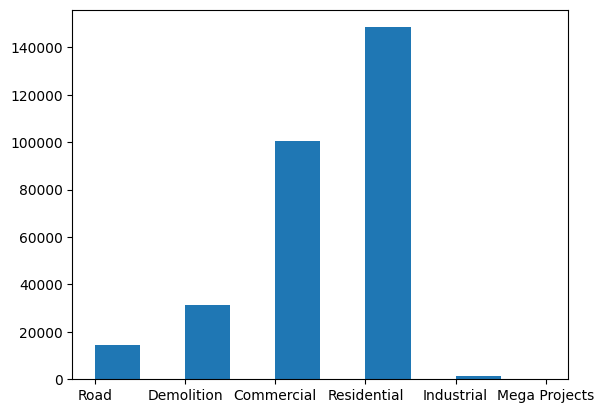

In [6]:
from matplotlib import pyplot as plt
plt.hist(train_df['change_type'])
plt.show()


In [7]:
def convert_date(x):
    if pd.isna(x):
        return pd.NaT
    try:
        return datetime.strptime(str(x), '%d-%m-%Y').date()
    except (ValueError, TypeError):
        return pd.NaT

In [8]:
def FormatData(df : gpd.GeoDataFrame) -> pd.DataFrame :
    """fomrmat the geopandas dataframe to a correct dataframe with one hoit encoded columns and normalized values

    Args:
        df (gpd.GeoDataFrame): The geopandas dataframe to format

    Returns:
        pd.DataFrame: The correct formated dataframe
    """
    #Convert urban types and geography types to one hot by hand, because mixed values are possible
    urban_types = df['urban_type'].str.split(',', expand = True)
    geography_types = df['geography_type'].str.split(',', expand = True)

    unique_urban_types = set(urban_types.values.flatten()) - {None}
    unique_geography_types = set(geography_types.values.flatten()) - {None}
    one_hot_encoded = pd.DataFrame(index=df.index)

    for urban_type in unique_urban_types:
        one_hot_encoded[urban_type] = urban_types.apply(lambda row: 1 if urban_type in row.values else 0, axis=1)

    for geography_type in unique_geography_types:
        one_hot_encoded[geography_type] = geography_types.apply(lambda row: 1 if geography_type in row.values else 0, axis=1)
    
    df_oh = pd.concat([df, one_hot_encoded], axis=1)
    df_oh = df_oh.drop(['urban_type', 'geography_type'], axis = 1)

    #one hot encode other categorical columns
    df_oh = pd.get_dummies(df_oh,columns=['change_status_date0',
    'change_status_date1', 'change_status_date2', 'change_status_date3',
    'change_status_date4'])

    #convert the geometry in intersting features
    df_oh.loc[:,'area'] = df_oh[['geometry']].area
    df_oh.loc[:,'length'] = df_oh[['geometry']].length

    return df_oh

In [9]:
columns_to_normalize = ['img_red_mean_date1', 'img_green_mean_date1',
       'img_blue_mean_date1', 'img_red_std_date1', 'img_green_std_date1',
       'img_blue_std_date1', 'img_red_mean_date2', 'img_green_mean_date2',
       'img_blue_mean_date2', 'img_red_std_date2', 'img_green_std_date2',
       'img_blue_std_date2', 'img_red_mean_date3', 'img_green_mean_date3',
       'img_blue_mean_date3', 'img_red_std_date3', 'img_green_std_date3',
       'img_blue_std_date3', 'img_red_mean_date4', 'img_green_mean_date4',
       'img_blue_mean_date4', 'img_red_std_date4', 'img_green_std_date4',
       'img_blue_std_date4', 'img_red_mean_date5', 'img_green_mean_date5',
       'img_blue_mean_date5', 'img_red_std_date5', 'img_green_std_date5',
       'img_blue_std_date5',  'date_dif1', 'date_dif2',
       'date_dif3', 'date_dif4']

In [10]:
def Normalize(df_oh, columns) :
    df_oh.loc[:,columns] = (df_oh.loc[:,columns] - df_oh.loc[:,columns].mean())/(df_oh.loc[:,columns].std())
    return df_oh

In [11]:
train_df_oh, test_df_oh = FormatData(train_df), FormatData(test_df)

C:\Users\bouet\AppData\Local\Temp\ipykernel_13408\1089497561.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_oh.loc[:,'area'] = df_oh[['geometry']].area
C:\Users\bouet\AppData\Local\Temp\ipykernel_13408\1089497561.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_oh.loc[:,'length'] = df_oh[['geometry']].length
C:\Users\bouet\AppData\Local\Temp\ipykernel_13408\1089497561.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_oh.loc[:,'area'] = df_oh[['geometry']].area
C:\Users\bouet\AppData\Local\Temp\ipykernel_13408\1089497561.py:34: UserWarning: Geometry is in a ge

In [12]:
train = train_df_oh.fillna(0)
test = test_df_oh.fillna(0)

In [13]:
train.loc[:,'date0'] = pd.to_datetime(train['date0'].apply(convert_date))
train.loc[:,'date1'] = pd.to_datetime(train['date1'].apply(convert_date))
train.loc[:,'date2'] = pd.to_datetime(train['date2'].apply(convert_date))
train.loc[:,'date3'] = pd.to_datetime(train['date3'].apply(convert_date))
train.loc[:,'date4'] = pd.to_datetime(train['date4'].apply(convert_date))

In [14]:
dif1 = []
dif2 = []
dif3 = []
dif4 = []

for i,dates in train.loc[:,['date0', 'date1', 'date2', 'date3', 'date4']].iterrows():
    dif1.append((dates['date1'] - dates['date0']).days)
    dif2.append((dates['date2'] - dates['date1']).days)
    dif3.append((dates['date3'] - dates['date2']).days)
    dif4.append((dates['date4'] - dates['date3']).days)

In [15]:
train.loc[:,'date_dif1'] = dif1
train.loc[:,'date_dif2'] = dif2
train.loc[:,'date_dif3'] = dif3   
train.loc[:,'date_dif4'] = dif4   


In [16]:
train = train.fillna(0)
test = test_df_oh.fillna(0)

In [17]:
train['date_dif1']

0        -1696.0
1        -1696.0
2        -1696.0
3        -1696.0
4        -1696.0
           ...  
296141     829.0
296142     829.0
296143     829.0
296144     829.0
296145     829.0
Name: date_dif1, Length: 296146, dtype: float64

# Outlier study

In [65]:
from matplotlib import pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay

[]

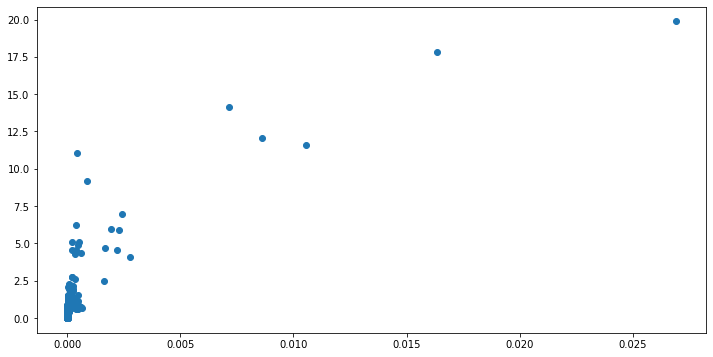

In [78]:
plt.scatter(train['area'], train['length'])
plt.plot()

In [152]:
clf = IsolationForest(max_samples = 1000)

In [ ]:
y = clf.fit_predict(train_df_oh.loc[:,['area','length']])
print(len(train_df_oh.loc[np.where(y == -1)[0], 'length']))
plt.figure(figsize = (20,20))

plt.scatter(train_df_oh.loc[np.where(y == -1)[0], 'area'],train_df_oh.loc[np.where(y == -1)[0], 'length'], c = 'r', label = 'outlier')
plt.scatter(train_df_oh.loc[np.where(y != -1)[0], 'area'],train_df_oh.loc[np.where(y != -1)[0], 'length'], c = 'b', label = 'inlier')
plt.legend()
plt.show()



In [155]:
train_df_oh_reduced = train_df_oh.loc[np.where(y != -1)[0]]

In [ ]:
plt.scatter(train_df_oh_reduced['length'],train_df_oh_reduced['area'], c = train_df_oh_reduced['change_type'].apply(lambda x: change_type_map[x]))
plt.show()

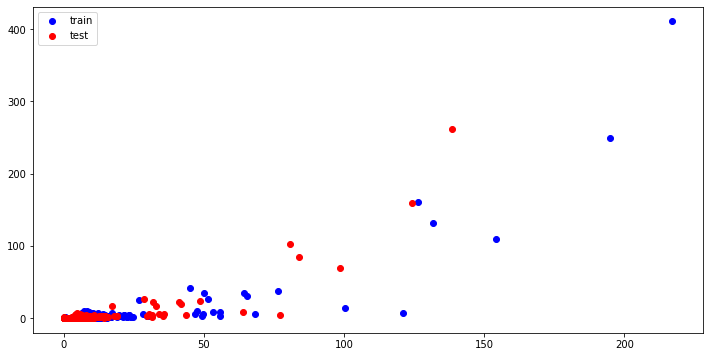

In [420]:
plt.scatter(train_df_oh['length'],train_df_oh['area'], c = 'b', label = 'train')
plt.scatter(test_df_oh['length'],test_df_oh['area'], c = 'r', label = 'test')
plt.legend()
plt.show()

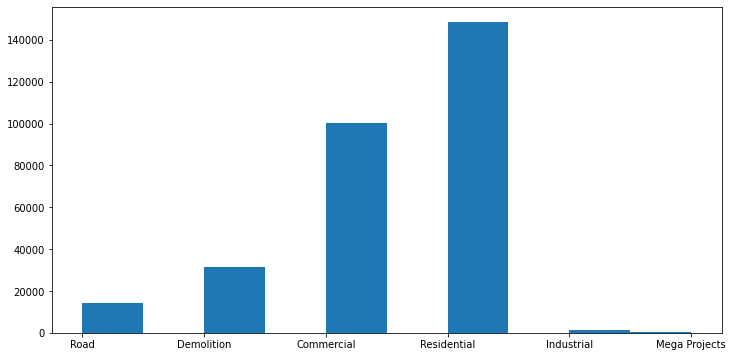

In [421]:
plt.hist(train_df_oh['change_type'])
plt.show()

In [159]:
print(test_df_oh.shape)
train_df_oh = train_df_oh.dropna(axis = 0)
test_df_oh = test_df_oh.dropna(axis = 0)
print(test_df_oh.shape)

(120526, 107)
(120526, 107)


# Other feature formating

In [136]:
train.loc[:,'change_type'] = train['change_type'].apply(lambda x: change_type_map[x])

Big inequalities in the number of samaples in the classes -> The accuracy of the models will be mainly bounded by the ratios of classes 2 and 3.
We will take only the number of samples of the class 1 (around 7000 samples), and drop the class 4 and five because their aren't enough examples of thoses classes

In [137]:
from sklearn.utils import shuffle

classes_to_keep = [0,1,2,3,4,5]
train = train.loc[train['change_type'].isin(classes_to_keep)] #we keep classes 0 to 3
numb_per_class = len(train.loc[train['change_type'] == 1])
train_df_balanced = pd.DataFrame()
for i in classes_to_keep :
    df_class = train.loc[train['change_type'] == i]
    df_class = df_class.sample(n=min(numb_per_class, len(df_class)))
    train_df_balanced = pd.concat([train_df_balanced,df_class])

train_df_balanced = shuffle(train_df_balanced).reset_index()

In [138]:
train_df_balanced.columns

Index(['level_0', 'change_type', 'img_red_mean_date1', 'img_green_mean_date1',
       'img_blue_mean_date1', 'img_red_std_date1', 'img_green_std_date1',
       'img_blue_std_date1', 'img_red_mean_date2', 'img_green_mean_date2',
       ...
       'change_status_date4_Materials Dumped',
       'change_status_date4_Materials Introduced',
       'change_status_date4_Operational',
       'change_status_date4_Prior Construction', 'area', 'length', 'date_dif1',
       'date_dif2', 'date_dif3', 'date_dif4'],
      dtype='object', length=113)

In [139]:
train_df_balanced = train_df_balanced.drop('index', axis = 1)

In [140]:
train_df_balanced = train_df_balanced.drop(['date0', 'date1', 'date2', 'date3','date4', 'N', 'A', 'geometry'], axis = 1)
train_df_balanced = train_df_balanced.drop(['level_0', 'Snow', 'length', 'area'], axis = 1)

In [141]:
test_df_oh = test_df_oh.drop(['date0', 'date1', 'date2', 'date3','date4', 'N', 'A', 'geometry', 'Snow','length', 'area'], axis = 1)

KeyError: "['date0', 'date1', 'date2', 'date3', 'date4', 'N', 'A', 'geometry', 'Snow', 'length', 'area'] not found in axis"

In [142]:
train_df_balanced = Normalize(train_df_balanced,columns_to_normalize)
# test_df_oh = Normalize(test_df_oh, columns_to_normalize)

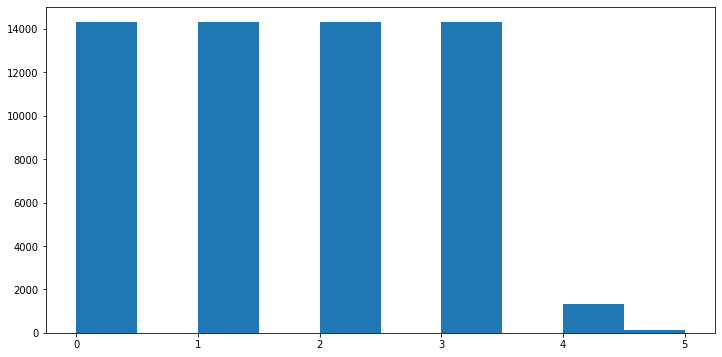

(58695, 100)


In [92]:
plt.hist(train_df_balanced['change_type'])
plt.show()
print(train_df_balanced.shape)

# Feature analysis

In [93]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

<Axes: >

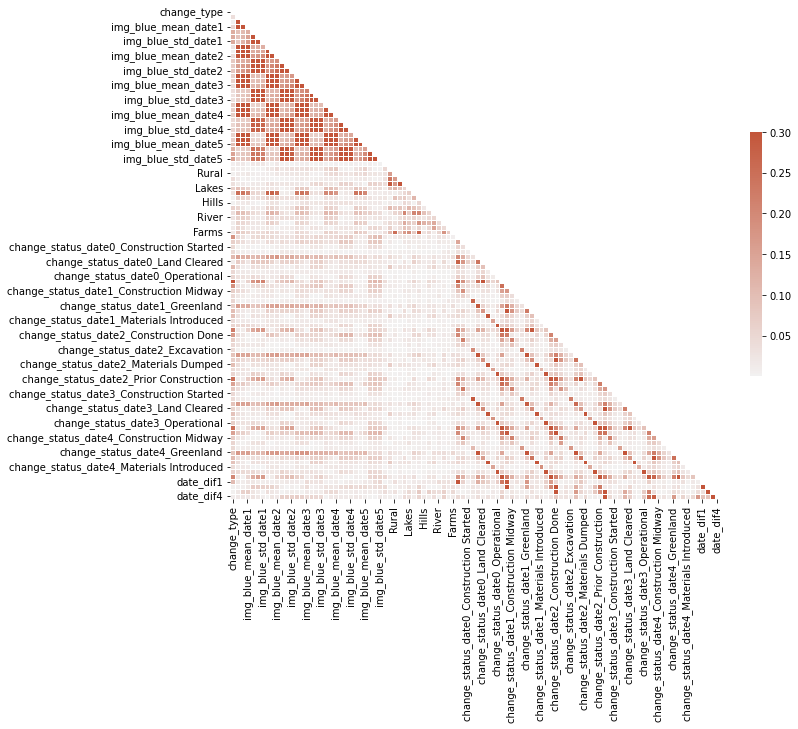

In [94]:
corr_matrix = train_df_balanced.corr().abs()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [143]:
target_cor_raw = pd.DataFrame(corr_matrix.loc['change_type']).sort_values(by='change_type', axis = 0)

best_features = target_cor_raw.loc[target_cor_raw['change_type'] > 0.02]

print(best_features)

                                        change_type
img_red_mean_date2                         0.027154
River                                      0.027970
Desert                                     0.028935
img_green_std_date3                        0.031589
img_blue_std_date3                         0.032284
...                                             ...
change_status_date1_Prior Construction     0.224303
change_status_date2_Prior Construction     0.244686
change_status_date3_Prior Construction     0.245779
change_status_date0_Prior Construction     0.328447
change_type                                1.000000

[86 rows x 1 columns]


In [144]:
train_df_balanced = train_df_balanced.loc[:,best_features.index]
# test_df_oh = test_df_oh.loc[:,best_features.drop('change_type', axis = 0).index]

In [145]:
train_df_X = train_df_balanced.drop(['change_type'], axis = 1)
train_df_Y = train_df_balanced['change_type']

## Dimensionality reduction : PCA

In [36]:
# N_COMP = train_df_X.shape[1]
N_COMP = 10

In [37]:
pca = PCA(n_components = N_COMP)
pca.fit(train_df_X)

PCA(n_components=10)

[0.51257975 0.62776689 0.70552197 0.77644314 0.84153262 0.88869667
 0.91186923 0.93313327 0.94741188 0.95956817]


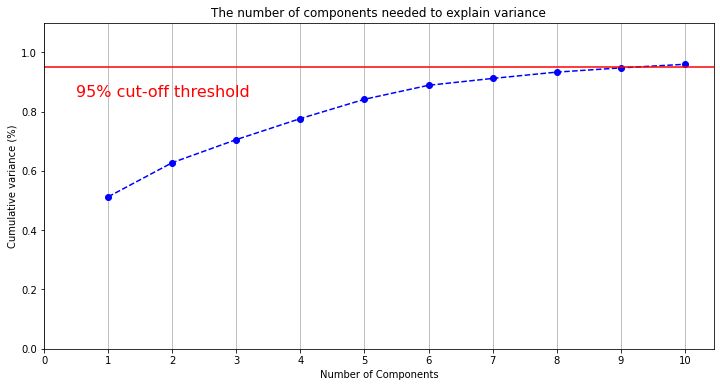

In [38]:

# matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, N_COMP + 1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
print(y)
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, N_COMP + 1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

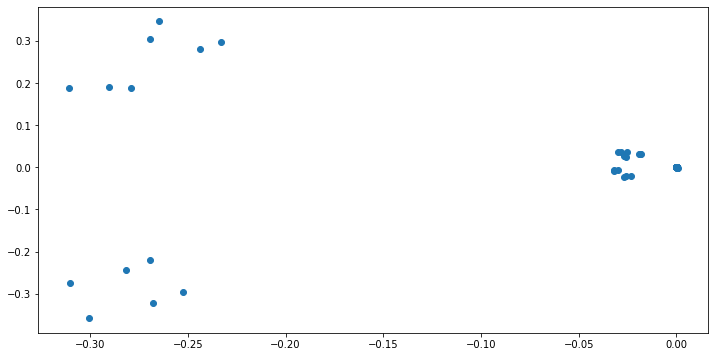

In [39]:
# Access the loadings (components_)
loadings = pca.components_

# Create a DataFrame for better visualization
loadings_df = pd.DataFrame(loadings, columns=train_df_X.columns)
plt.scatter(loadings[0], loadings[1])
plt.show()


In [556]:
X_pca = pca.fit_transform(train_df_X)

# Data split

In [146]:
train_X, train_Y = np.asarray(train_df_X, dtype = np.float32), np.asarray(train_df_Y, dtype= np.int32)
# test_x = pca.fit_transform(test_df_oh)
# test_x = np.asarray(test_df_oh.loc[:,best_features.drop('change_type', axis = 0).index])

In [147]:
split_ratio = 0.8

train_x, val_x = train_X[:int(len(train_X)*split_ratio)], train_X[int(len(train_X)*split_ratio):]
train_y, val_y = train_Y[:int(len(train_X)*split_ratio)], train_Y[int(len(train_X)*split_ratio):]

In [148]:
print(train_x.shape)
print(val_x.shape)

(46956, 85)
(11739, 85)


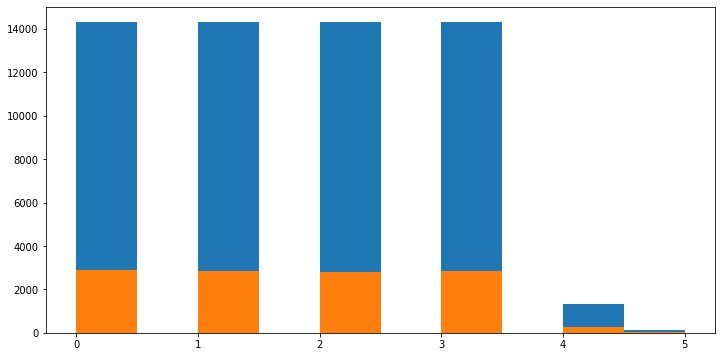

In [149]:
plt.hist(train_Y, label = 'Train')
plt.hist(val_y,label='Validation')
plt.show()

# First model

In [150]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from tqdm import tqdm

In [151]:
accuracies = []
for neighbors in tqdm(range(3,31)) : 
    neigh = KNeighborsClassifier(n_neighbors=neighbors)
    neigh.fit(train_x, train_y)
    pred_y = neigh.predict(val_x)
    accuracies.append(accuracy_score(val_y, pred_y))

100%|██████████| 28/28 [00:27<00:00,  1.02it/s]


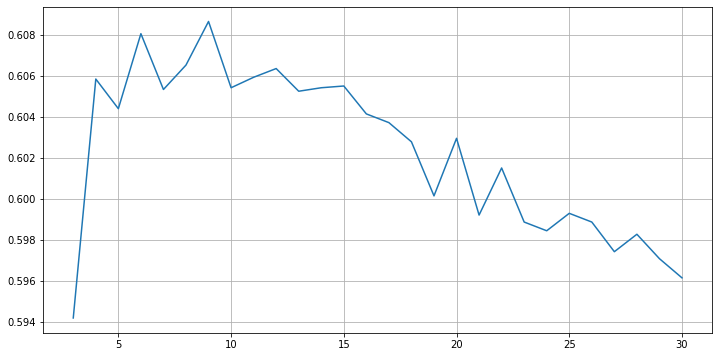

Best accuracie achieved : 0.6086549109804924


In [152]:
plt.plot(range(3,31), accuracies)
plt.grid(True)
plt.show()

print(f"Best accuracie achieved : {max(accuracies)}")


Best accuracy : 0.61

In [153]:
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(train_x, train_y)
pred_y = neigh.predict(val_x)
# acc= accuracy_score(val_y,pred_y)

In [154]:
print(confusion_matrix(val_y,pred_y))
print(f"Mean f1 score: {f1_score(val_y, pred_y, average = 'micro' )}")

[[2360  164  245  120    0    0]
 [ 179 2123  306  250    0    0]
 [ 270  572 1564  410    0    0]
 [ 312  858  682 1003   12    0]
 [  26   54   68   97   28    0]
 [   5   10   13    8    0    0]]
Mean f1 score: 0.6029474401567425


# Second model

In [156]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [157]:
decTree = DecisionTreeClassifier()
decTree.fit(train_x, train_y)
pred_y = decTree.predict(val_x)
print(accuracy_score(val_y, pred_y))

0.5543061589573217


Best accuracy : 0.51

# Third model

In [158]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
accuracies = []
randFor = GradientBoostingClassifier()
randFor.fit(train_x, train_y)
pred_y = randFor.predict(val_x)
acc = accuracy_score(val_y, pred_y)
print(acc)
accuracies.append(acc)

Best accuracy : 0.59

# Fourth model

In [356]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
svc = SVC(gamma=2, C=1)
svc.fit(train_x, train_y)
pred_y = svc.predict(val_x)
acc = accuracy_score(val_y, pred_y)
print(acc)


Best accuracy :

# Neural network

In [159]:
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

device = torch.device('cpu')
print(torch.cuda.is_available())

True


In [178]:
class SimpleNN(nn.Module):
    def __init__(self,n_input,n_neurones):
        super(SimpleNN,self).__init__()
        self.layer1 = nn.Linear(n_input,n_neurones)
        self.layer2 = nn.Linear(n_neurones, int(n_neurones/3))
        self.layer3 = nn.Linear(int(n_neurones/3),6)
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [161]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    for x, labels in torch.utils.data.DataLoader(data, batch_size=64):
        x = x.to(device)
        labels = labels.to(device)
        output = model(x)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).cpu().detach().sum().item()
        total += x.cpu().detach().shape[0]
    return correct / total
  


In [181]:
def train(model, train_data, val_data, batch_size=64, num_epochs=1 , print_stat = 1):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)
    # criterion = nn.MultiMarginLoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00002)
    # scheduler = lr_scheduler.LinearLR(optimizer,start_factor=1.0, end_factor=0.005, total_iters=num_epochs/2)


    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for x, labels in iter(train_loader):
            x = x.to(device)
            labels = labels.to(device)
            out = model(x)            
            loss = criterion(out, labels)
            
            loss.backward()               
            
            optimizer.step()
                      
            optimizer.zero_grad()         

            # save the current training information
            iters.append(n)
            train_loss = float(loss.cpu().detach())/batch_size
                     
            n += 1
        losses.append(train_loss)    
        train_accu,val_accu = get_accuracy(model, train_data),get_accuracy(model, val_data)
        train_acc.append(train_accu) # compute training accuracy 
        val_acc.append(val_accu)  # compute validation accuracy

        # scheduler.step()
        lr = optimizer.param_groups[0]["lr"]
        print(f"Epoch {epoch}, Train Loss: {train_loss}, Train accuracy: {train_accu}, Validation accuracy: {val_accu}, Learning rate: {lr}")

    if print_stat:
      # plotting
      plt.title("Training Curve")
      plt.plot(range(num_epochs), losses, label="Train")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.show()

      plt.title("Training Curve")
      plt.plot(range(num_epochs), train_acc, label="Train")
      plt.plot(range(num_epochs), val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      plt.show()

      print("Final Training Accuracy: {}".format(train_acc[-1]))
      print("Final Validation Accuracy: {}".format(val_acc[-1]))
    
    
    
print('done')

done


In [182]:
split_ratio = 0.8

train_x, val_x = train_X[:int(len(train_X)*split_ratio)], train_X[int(len(train_X)*split_ratio):]
train_y, val_y = train_Y[:int(len(train_X)*split_ratio)], train_Y[int(len(train_X)*split_ratio):]

In [185]:
model = SimpleNN(train_x.shape[1], 80)
model = model.to(device)

In [165]:
train_x.shape
model

SimpleNN(
  (layer1): Linear(in_features=85, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=6, bias=True)
)

In [166]:
train_x = np.array(train_x, dtype = np.float32)
val_x = np.array(val_x, dtype = np.float32)

In [167]:
X = torch.Tensor(train_x)
Y=torch.Tensor(train_y)
Y = Y.type(torch.LongTensor)
train_data = data_utils.TensorDataset(X,Y)

X_ = torch.Tensor(val_x)
Y_=torch.Tensor(val_y)
Y_ = Y_.type(torch.LongTensor)
val_data = data_utils.TensorDataset(X_,Y_)


Epoch 0, Train Loss: 0.009329720089832941, Train accuracy: 0.10494931425163984, Validation accuracy: 0.11125308799727404, Learning rate: 2e-05
Epoch 1, Train Loss: 0.009091071784496307, Train accuracy: 0.2424184342788994, Validation accuracy: 0.24295084760201038, Learning rate: 2e-05
Epoch 2, Train Loss: 0.008812392130494118, Train accuracy: 0.2600306670074112, Validation accuracy: 0.2599880739415623, Learning rate: 2e-05
Epoch 3, Train Loss: 0.008299199243386587, Train accuracy: 0.32602862254025045, Validation accuracy: 0.32694437345600136, Learning rate: 2e-05
Epoch 4, Train Loss: 0.007830562690893808, Train accuracy: 0.39226083993525857, Validation accuracy: 0.3936451145753471, Learning rate: 2e-05
Epoch 5, Train Loss: 0.007584244633714358, Train accuracy: 0.4221824686940966, Validation accuracy: 0.4206491183235369, Learning rate: 2e-05
Epoch 6, Train Loss: 0.007509659354885419, Train accuracy: 0.4338742652696141, Validation accuracy: 0.43368259647329416, Learning rate: 2e-05
Epoch 

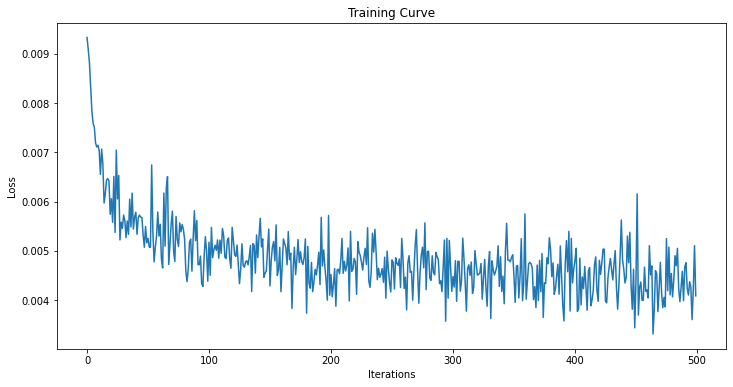

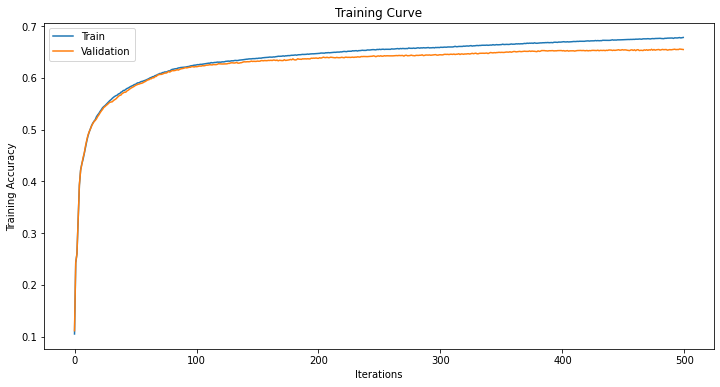

Final Training Accuracy: 0.6782093875117131
Final Validation Accuracy: 0.6549109804923758


In [186]:
train(model, train_data = train_data, val_data = val_data, num_epochs = 500, batch_size = 192)

In [187]:
pred_y = []

for x, labels in torch.utils.data.DataLoader(val_data, batch_size=1):
    with torch.no_grad():
        model = model.cpu()
        output = model(x)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        pred_y.append(pred.item())

pred_y = np.array(pred_y)

In [188]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

print(confusion_matrix(val_y,pred_y))
print(f"Mean f1 score: {f1_score(val_y, pred_y, average = 'macro' )}")

[[2599   78   87  123    2    0]
 [  55 1932  412  459    0    0]
 [ 147  391 1707  569    2    0]
 [ 160  541  743 1409   14    0]
 [  18   41   65  108   41    0]
 [   3    9   11   13    0    0]]
Mean f1 score: 0.4808815462115408


In [64]:
# test_x = pca.fit_transform(test_df_oh)
# print(test_x.shape)

# Test and create submission

In [609]:
X = torch.Tensor(np.array(test_x, dtype=np.float32))
preds = []
for x in X:
    with torch.no_grad():
        model = model.cpu()
        output = model(x)
        #select index with maximum prediction score
        pred = output.max(0, keepdim=True)[1]
        preds.append(pred.item())
submission_df = pd.DataFrame({'change_type': preds})
submission_df.to_csv("nn_submission.csv", index=True, index_label='Id')
